# Overall

In order to train the SinVAR, normally, it includes to train the VAE first. However, given the time-horizon for the current project, 
and to stay with the original VAR paper, I will use the pretrained VQVAE as they have used. However, I will look into fine-tune the VQVAE if possible. 

Then, after the VQVAE, we have to train the VAR.

In [1]:
import torch
import torch.nn as nn
from typing import Tuple

In [2]:
from vqvae import VQVAE
from var import VAR


def build_vae_var(
        # Shared args
        device, patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16),  # 10 steps by default
        # VQVAE args
        V=4096, Cvae=32, ch=160, share_quant_resi=4,
        # VAR args
        depth=16, attn_l2_norm=True,
        init_head=0.02, init_std=-1,  # init_std < 0: automated
) -> Tuple[VQVAE, VAR]:
    heads = depth
    width = depth * 64          
    dpr = 0.1 * depth / 24

    # disable built-in initialization for speed
    for clz in (nn.Linear, nn.LayerNorm, nn.BatchNorm2d, nn.SyncBatchNorm, nn.Conv1d, nn.Conv2d, nn.ConvTranspose1d,
                nn.ConvTranspose2d):
        setattr(clz, 'reset_parameters', lambda self: None)

    # build models
    vae_local = VQVAE(vocab_size=V, z_channels=Cvae, ch=ch, test_mode=True, share_quant_resi=share_quant_resi,
                      v_patch_nums=patch_nums).to(device)
    var_wo_ddp = VAR(
        vae_local=vae_local,
        depth=depth, embed_dim=width, num_heads=heads, drop_rate=0., attn_drop_rate=0., drop_path_rate=dpr,
        norm_eps=1e-6,
        attn_l2_norm=attn_l2_norm,
        patch_nums=patch_nums,
    ).to(device)
    var_wo_ddp.init_weights(init_head=init_head, init_std=init_std)

    return vae_local, var_wo_ddp

## VQVAE

- Loading from the Hugging Face
- Trying to Reconstruct on Random Crop

In [3]:
vae_var_config = {
    # Shared
    "device": torch.device("mps" if torch.mps.is_available() else "cpu"),
    # "patch_nums": (1, 2, 3, 4, 5, 6, 8, 10, 13, 16),
    "patch_nums": (1, 2, 3, 4, 5, 6, 8),

    # VAR config (customizable for your setup)
    "depth": 10,  # VAR transformer depth
    "attn_l2_norm": True,

    # Initialisation options (irrelevant for non-adaptive setup)
    "init_head": 0.02,
    "init_std": -1,  # Use default init scheme
}

In [4]:
vae_local, var_wo_ddp = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,  # hard-coded VQVAE hyperparameters
    device=vae_var_config['device'],
    depth=vae_var_config['depth'], attn_l2_norm=vae_var_config['attn_l2_norm'],
    init_head=vae_var_config['init_head'], init_std=vae_var_config['init_std'],
    patch_nums=vae_var_config['patch_nums']
)


[constructor]  ==== UNCONDITIONAL VAR: using SelfAttnBlock (10 blocks, no class label) ====
    [VAR config ] embed_dim=640, num_heads=10, depth=10
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0416667 (tensor([0.0000, 0.0046, 0.0093, 0.0139, 0.0185, 0.0231, 0.0278, 0.0324, 0.0370,
        0.0417]))

[init_weights] VAR with init_std=0.0228218


In [5]:
# download checkpoint for VQVAE
import os
import os.path as osp

# Download from Hugging Face
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt = 'vae_ch160v4096z32.pth'
local_path = './pretrained-models'
if not osp.exists(os.path.join(local_path, vae_ckpt)): os.system(f'wget {hf_home}/{vae_ckpt}')

# load checkpoints
vae_local.load_state_dict(torch.load(os.path.join(local_path, vae_ckpt), map_location=vae_var_config['device']),
                          strict=True)

<All keys matched successfully>

In [6]:
count_p = lambda m: f'{sum(p.numel() for p in m.parameters()) / 1e6:.2f}'
print(f'[INIT][#para] ' + ', '.join([f'{k}={count_p(m)}' for k, m in (
('VAE', vae_local), ('VAE.enc', vae_local.encoder), ('VAE.dec', vae_local.decoder),
('VAE.quant', vae_local.quantize))]))
print(f'[INIT][#para] ' + ', '.join([f'{k}={count_p(m)}' for k, m in (('VAR', var_wo_ddp),)]) + '\n\n')

[INIT][#para] VAE=108.95, VAE.enc=44.11, VAE.dec=64.65, VAE.quant=0.17
[INIT][#para] VAR=51.98




In [7]:
# Move it to mps for quicker inference
# vae_local.to(torch.device('mps'))

device = next(vae_local.parameters()).device
print(f"Current Device: {device}")

Current Device: mps:0


In [8]:
def get_model_size_mb(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params * 4 / (1024 ** 2)  # Convert bytes to MB


def print_module_param_counts(model, name='', indent=0):
    total_params = 0
    sub_modules = dict(model.named_children())

    if not sub_modules:  # leaf node
        count = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print('  ' * indent + f'{name or model.__class__.__name__}: {count:,} params')
        return count

    print('  ' * indent + f'{name or model.__class__.__name__}:')
    for sub_name, sub_module in sub_modules.items():
        full_name = f'{name}.{sub_name}' if name else sub_name
        count = print_module_param_counts(sub_module, name=full_name, indent=indent + 1)
        total_params += count

    return total_params


model_size_mb = get_model_size_mb(var_wo_ddp)
total = print_module_param_counts(var_wo_ddp, name='VAR')
print(f'\n[Total Encoder Params] {total:,}')
print(f"Estimated model size: {model_size_mb:.2f} MB")


VAR:
  VAR.word_embed: 21,120 params
  VAR.lvl_embed: 4,480 params
  VAR.blocks:
    VAR.blocks.0:
      VAR.blocks.0.drop_path: 0 params
      VAR.blocks.0.attn:
        VAR.blocks.0.attn.mat_qkv: 1,228,800 params
        VAR.blocks.0.attn.proj: 410,240 params
        VAR.blocks.0.attn.proj_drop: 0 params
      VAR.blocks.0.ffn:
        VAR.blocks.0.ffn.fc1: 1,640,960 params
        VAR.blocks.0.ffn.act: 0 params
        VAR.blocks.0.ffn.fc2: 1,639,040 params
        VAR.blocks.0.ffn.drop: 0 params
      VAR.blocks.0.ln1: 1,280 params
      VAR.blocks.0.ln2: 1,280 params
    VAR.blocks.1:
      VAR.blocks.1.drop_path: 0 params
      VAR.blocks.1.attn:
        VAR.blocks.1.attn.mat_qkv: 1,228,800 params
        VAR.blocks.1.attn.proj: 410,240 params
        VAR.blocks.1.attn.proj_drop: 0 params
      VAR.blocks.1.ffn:
        VAR.blocks.1.ffn.fc1: 1,640,960 params
        VAR.blocks.1.ffn.act: 0 params
        VAR.blocks.1.ffn.fc2: 1,639,040 params
        VAR.blocks.1.ffn.drop: 0 para

## Data

In order to either test the loaded model or to train the var, we need to first have a dataset.

### `Dataset` Object

This is the dataset object. Note that this dataset only has one image.

Image dimension: height=3744, width=5616, channel=3
Image dtype: dtype=dtype('uint8')


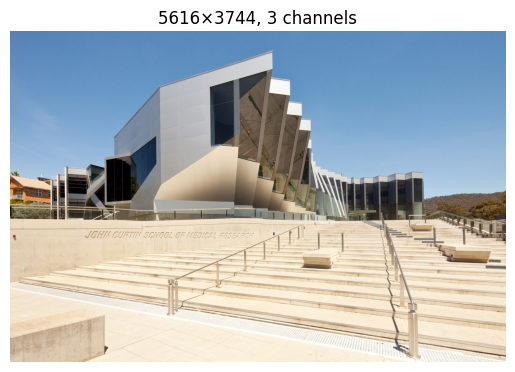

In [9]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

image: np.ndarray = io.imread('./data/jcsmr.jpg')
height, width = image.shape[:2]
channel = image.shape[2] if image.ndim == 3 else 1
dtype = image.dtype

print(f"Image dimension: {height=}, {width=}, {channel=}")
print(f"Image dtype: {dtype=}")

plt.imshow(image)
plt.title(f"{width}×{height}, {channel} channels")
plt.axis("off")
plt.show()

## Transformed Images

Now, we need to have a way smaller image to learn for the transformer given the hardware constraint. 
Therefore, I will scale down the image so that it is small enough to train on but also meaningful enough to make edits on.

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image, affine, crop

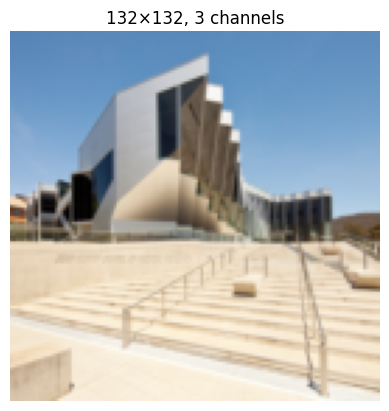

In [11]:
pre_dataset_size = 132

pre_dataset_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(pre_dataset_size, int(pre_dataset_size * 1.1))),
    v2.CenterCrop(size=pre_dataset_size)
])

transformed_image = pre_dataset_transform(image)

transformed_image_np = transformed_image.permute(1, 2, 0).numpy()

height, width = transformed_image_np.shape[:2]
channel = transformed_image_np.shape[2] if transformed_image_np.ndim == 3 else 1
dtype = transformed_image_np.dtype

plt.imshow(transformed_image_np)
plt.title(f"{width}×{height}, {channel} channels")
plt.axis("off")
plt.show()

plt.imsave("./data/transformed_image.jpg", transformed_image_np)


In [12]:
class SingleImageDataset(Dataset):
    """
    The single image dataset
    """

    def __init__(self, image_path, transform, seed, train=True):
        """
        This is the single Image dataset. Note that the single image dataset contains only one image. Therefore, it is important note that it is important to use random cropping and other
        transforming methods to augment the dataset.
        
        :param image_path: This is the path of the data.
        :param transform: Normally, this is optional. However, it is required for this dataset given that it has only one image. Also, please use some corpping.
        """
        self.image_path = image_path
        self.image = io.imread(image_path)
        self.transform = transform
        self.seed = seed
        self.train = train

    def __len__(self):
        return 1024 if self.train else 256  # This may seem to be an unusually small dataset but given that the model is quite complex and also simply just the fact that 256x256 would simply cover the whole model with about 10 - 20 images minimum.

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, list):
            return [self.__getitem__(i) for i in idx]

        if not isinstance(idx, int):
            raise TypeError(f"`idx` must be an integer or a list but got {type(idx)}")

        # Set deterministic augmentation for given idx
        torch.manual_seed(self.seed + idx)
        return self.transform(self.image)

### `Transform`

Then, we need to define the transform to use.

In [13]:
training_config = dict(
    fused=None,
    lr=8e-4,
    n_gradient_accumulation=1,
    tclip=1.0,
    label_smoothing=0.1,
    input_data_resolution=128,
    training_batch_size=32,
    validation_batch_size=32,
    test_batch_size=32,
    device=vae_var_config['device'],
    validation_device=vae_var_config['device'],
    epochs=100,
)

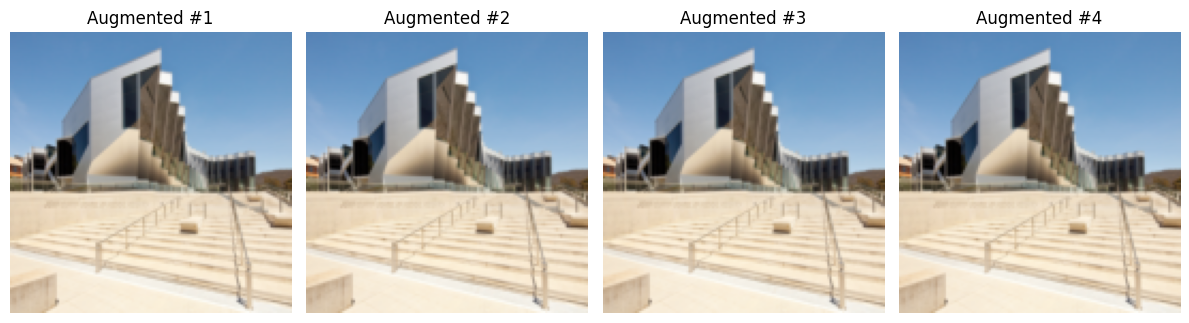

In [14]:
preview_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=training_config['input_data_resolution'], scale=(0.85, 1)),
    # v2.RandomPerspective(distortion_scale=0.3, p=0.5),    # This transformation causes unwanted padding, so I ended up disabling
    # v2.RandomHorizontalFlip(p=0.5),                       # This transformation causes unwanted results by having part of the image flipped
                                                            # See model v0.5.0 for results
    # v2.RandomRotation(degrees=5),                         # This transformation causes unwanted padding, so I ended up disabling
    # v2.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.05),   # This causes the model to be incapable of learning the tone of the photo.
])

# Generate and display augmented images
plt.figure(figsize=(12, 4))
for i in range(4):
    aug = preview_transform(transformed_image)
    img_pil = to_pil_image(transformed_image)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_pil)
    plt.title(f'Augmented #{i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
image_path = './data/transformed_image.jpg'
train_transform = v2.Compose([
    preview_transform,
    v2.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])
train_dataset = SingleImageDataset(image_path, transform=train_transform, seed=42)
train_loader = DataLoader(train_dataset, batch_size=training_config['training_batch_size'], shuffle=True)

val_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=training_config['input_data_resolution'], scale=(0.95, 1), ratio=(1, 1)),
    v2.Normalize([0.5] * 3, [0.5] * 3),
])
val_dataset = SingleImageDataset(image_path, transform=val_transform, seed=1234567891, train=False)
val_loader = DataLoader(val_dataset, batch_size=training_config['validation_batch_size'], shuffle=False)

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=training_config['input_data_resolution'], scale=(0.95, 1), ratio=(1, 1)),
])
test_dataset = SingleImageDataset(image_path, transform=test_transform, seed=9876543210, train=False)
test_loader = DataLoader(test_dataset, batch_size=training_config['test_batch_size'], shuffle=False)

## VQVAE Validation

First, I want to make sure that the VQVAE is reconstructing correctly.

256


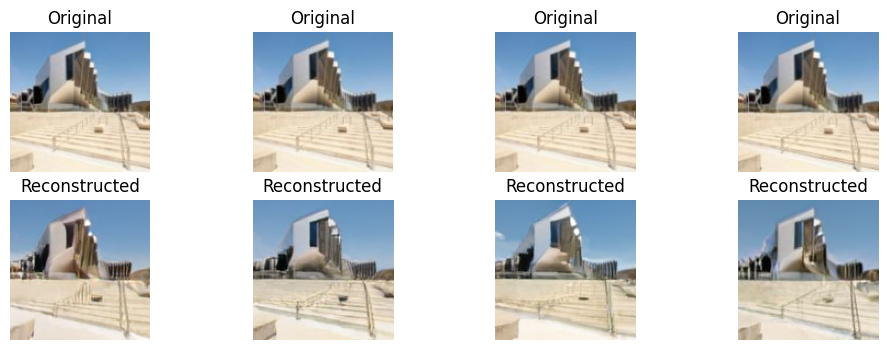

In [16]:
from torchvision.transforms.functional import normalize


def denorm(x: torch.Tensor):
    return normalize(x, mean=[-1] * 3, std=[1 / 0.5] * 3)


def show_vqvae_reconstruction(vae: VQVAE, dataloader, device, num_images=4):
    vae.eval()
    batch: torch.Tensor = next(iter(dataloader))[:num_images].to(device)
    # print(batch.shape)    # [B, C, H, W] as expected

    with torch.no_grad():
        recon = vae.img_to_reconstructed_img(x=batch, last_one=True)
    
    # Visualisation
    plt.figure(figsize=(12, 4))
    for i in range(batch.shape[0]):
        # Original
        plt.subplot(2, batch.shape[0], i + 1)
        plt.imshow(to_pil_image(denorm(batch[i].cpu())))
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        plt.subplot(2, batch.shape[0], i + 1 + batch.shape[0])
        plt.imshow(to_pil_image(denorm(recon[i].cpu())))
        plt.title("Reconstructed")
        plt.axis("off")


print(len(val_dataset))
show_vqvae_reconstruction(vae_local, val_loader, vae_var_config['device'], num_images=4)

✅ Image downloaded and saved as 'imagenet_sample.jpg'


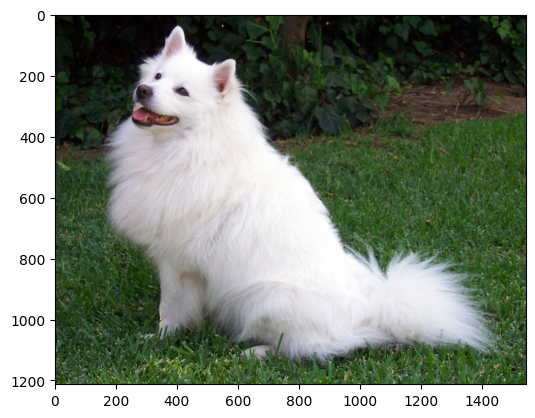

In [17]:
import requests
from PIL import Image
from io import BytesIO

# URL of an ImageNet sample image (Labrador Retriever)
img_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
filename = "imagenet_sample.jpg"  # Save as this filename

# Download and save
response = requests.get(img_url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img.save(filename)

print(f"✅ Image downloaded and saved as '{filename}'")

plt.imshow(img)

In [18]:
img_tensor: torch.Tensor = test_transform(img).unsqueeze(0).to(vae_var_config['device'])  # [1, 3, 256, 256]
img_tensor.shape, img_tensor.device

(torch.Size([1, 3, 128, 128]), device(type='mps', index=0))

(-0.5, 127.5, 127.5, -0.5)

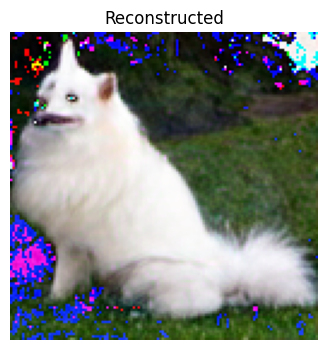

In [19]:
with torch.no_grad():
    recon = vae_local.img_to_reconstructed_img(x=img_tensor, last_one=True)

# --- Visualization --- #
plt.figure(figsize=(12, 4))
# Original
plt.imshow(to_pil_image((img_tensor[0].cpu())))
plt.title("Original")
plt.axis("off")

# Reconstructed
plt.imshow(to_pil_image((recon[0].cpu())))
plt.title("Reconstructed")
plt.axis("off")

# VAR Training

Now, given that most of the VQVAE part are working correctly, we will proceed to training the VAR model.

### Check model device

Everything should be on mps.

In [20]:
device = next(vae_local.parameters()).device
print(f"Current Device: {device}")

Current Device: mps:0


## Loss Function

Will use the cross entropy loss.

In [21]:
training_loss_func = nn.CrossEntropyLoss(label_smoothing=training_config['label_smoothing'], reduction='none')
val_loss_func = nn.CrossEntropyLoss(label_smoothing=0.0, reduction='mean')

In [22]:
import time

last_l = vae_var_config['patch_nums'][-1] * vae_var_config['patch_nums'][-1]

@torch.no_grad()
def eval_step(ld_val: DataLoader):
    tot = 0
    num_iters = len(ld_val)
    val_device = training_config['validation_device']
    val_dtype = torch.float32
    # L_mean, L_tail, acc_mean, acc_tail = torch.tensor(0., device=val_device), torch.tensor(0., device=val_device), torch.tensor(0, device=val_device), torch.tensor(0, device=val_device)
    L_mean = torch.tensor(0, device=val_device, dtype=val_dtype)
    L_tail = torch.tensor(0, device=val_device, dtype=val_dtype)
    acc_mean = torch.tensor(0, device=val_device, dtype=val_dtype)
    acc_tail = torch.tensor(0, device=val_device, dtype=val_dtype)
    stt = time.time()
    training = var_wo_ddp.training
    var_wo_ddp.eval()
    B, V = training_config['validation_batch_size'], vae_local.vocab_size
    for inp_B3HW in ld_val:
        inp_B3HW = inp_B3HW.to('mps', non_blocking=True)

        gt_idx_Bl: List[torch.LongTensor] = vae_local.img_to_idxBl(inp_B3HW)
        gt_BL = torch.cat(gt_idx_Bl, dim=1)
        x_BLCv_wo_first_l: torch.Tensor = vae_local.quantize.idxBl_to_var_input(gt_idx_Bl)

        # self.var_wo_ddp.forward
        logits_BLV: torch.Tensor = var_wo_ddp(x_BLCv_wo_first_l)
        pred_BL: torch.Tensor = logits_BLV.data.argmax(dim=-1)
        L_mean += val_loss_func(logits_BLV.data.view(-1, V), gt_BL.view(-1)) * B
        L_tail += val_loss_func(logits_BLV.data[:, -last_l:].reshape(-1, V), gt_BL[:, -last_l:].reshape(-1)) * B 
        acc_mean += (pred_BL == gt_BL).float().mean().item() * 100
        acc_tail += (pred_BL[:, -last_l:] == gt_BL[:, -last_l:]).float().mean().item() * 100
        # print((pred_BL == gt_BL).float().mean().item() * 100)
        tot += B
    var_wo_ddp.train(training)
    
    return L_mean.item() / num_iters, L_tail.item() / num_iters, acc_mean.item() / num_iters, acc_tail.item() / num_iters, tot, time.time() - stt


In [23]:
eval_step(val_loader)       # Clearly the model is far from being good.

(266.17547607421875, 266.1943054199219, 0.0, 0.0, 256, 9.795267820358276)

## Optimiser

I will use the AdamW Optimiser.

In [24]:
optimiser = torch.optim.AdamW(var_wo_ddp.parameters(), lr=training_config['lr'])

### Loggers

The first one is the imported ones. The second one is the one I have implemented.

In [26]:
from SinVAR.utils import misc
from SinVAR.utils.misc import TensorboardLogger

me = misc.MetricLogger(delimiter='  ')
[me.add_meter(x, misc.SmoothedValue(fmt='{median:.3f} ({global_avg:.3f})')) for x in ['Lm', 'Lt']]
[me.add_meter(x, misc.SmoothedValue(fmt='{median:.2f} ({global_avg:.2f})')) for x in ['Accm', 'Acct']]

[None, None]

In [27]:
from torch.utils.tensorboard import SummaryWriter
import torch

# Setup
model_name=f'v0.5.1_depth={vae_var_config['depth']}_train_size={len(train_dataset)}_epoc={training_config["epochs"]}'
custom_tb_lg = SummaryWriter(log_dir=f'./runs/var_training/{model_name}', filename_suffix='_train')

## Training Loop

This is the main training and evaluation loop.

In [28]:
from typing import List

num_epochs = training_config.get("epochs", 10)
prog_wp_it = 20  # or whatever warmup you prefer

var_wo_ddp.train()  # ensure model is in training mode
vae_local.eval()  # We are not training the vqvae here

V = vae_local.vocab_size
L = sum(pn * pn for pn in vae_var_config['patch_nums'])
loss_weight = torch.ones(1, L, device=device) / L
iters_per_epoch = len(train_loader)

best_recon_accuracy = 0.

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for it, inp_B3HW in enumerate(train_loader):  # assuming you already have train_loader
        inp_B3HW = inp_B3HW.to(training_config["device"])
        
        B = inp_B3HW.size(0)

        # Obtaining Embeddings
        gt_idx_Bl: List[torch.LongTensor] = vae_local.img_to_idxBl(inp_B3HW)
        gt_BL = torch.cat(gt_idx_Bl, dim=1)
        x_BLCvF_wo_first_l: torch.Tensor = vae_local.quantize.idxBl_to_var_input(gt_idx_Bl)

        # VAR Forward
        logits_BLV = var_wo_ddp(x_BLCvF_wo_first_l)

        # Loss
        train_loss = training_loss_func(logits_BLV.view(-1, V), gt_BL.view(-1)).view(B, -1)
        train_loss = train_loss.mul(loss_weight).sum(dim=-1).mean()

        # Backward
        train_loss.backward(retain_graph=False, create_graph=False)
        optimiser.step()
        optimiser.zero_grad(set_to_none=True)

        # Logging
        pred_BL: torch.Tensor = logits_BLV.data.argmax(dim=-1)
        Lmean = val_loss_func(logits_BLV.data.view(-1, V), gt_BL.view(-1)).item()
        Ltail = val_loss_func(logits_BLV.data[:, -last_l:].reshape(-1, V), gt_BL[:, -last_l:].reshape(-1)).item()
        acc_mean = (pred_BL == gt_BL).float().mean().item() * 100
        acc_tail = (pred_BL[:, -last_l:] == gt_BL[:, -last_l:]).float().mean().item() * 100
        
        # Logging to Metric Logger
        me.update(Lm=Lmean, Lt=Ltail, Accm=acc_mean, Acct=acc_tail)
        
        g_it = epoch * iters_per_epoch + it
        
        # Logging to custom tensorboard
        custom_tb_lg.add_scalar('Training/train_loss', train_loss.item(), global_step=epoch * iters_per_epoch + it)
        custom_tb_lg.add_scalar('Training/mean_loss', Lmean, global_step=epoch * iters_per_epoch + it)
        custom_tb_lg.add_scalar('Training/recon_loss', Ltail, global_step=epoch * iters_per_epoch + it)
        custom_tb_lg.add_scalar('Training/mean_accuracy', acc_mean, global_step=epoch * iters_per_epoch + it)
        custom_tb_lg.add_scalar('Training/recon_accuracy', acc_tail, global_step=epoch * iters_per_epoch + it)
        
        # print(f"[NOTEBOOK_LOG]: {it=}, {train_loss=}")

    Lm, Lt, accm, acct, tot, sec = eval_step(val_loader)
    print(f"Validation: {Lm=}, {Lt=}, {accm=}, {acct=}, {tot=}, {sec=}")
    
    if acct > best_recon_accuracy:
        best_recon_accuracy = acct
        torch.save(var_wo_ddp, f"./runs/models/var_training_{model_name}_best_val.pth")
    
    # Logging validation to custom tensorboard
    custom_tb_lg.add_scalar('Validation/mean_loss', Lm, global_step=epoch)
    custom_tb_lg.add_scalar('Validation/recon_loss', Lt, global_step=epoch)
    custom_tb_lg.add_scalar('Validation/mean_accuracy', accm, global_step=epoch)
    custom_tb_lg.add_scalar('Validation/recon_accuracy', acct, global_step=epoch)
    custom_tb_lg.add_scalar('Validation/time', sec, global_step=epoch)

    # Flush to TensorBoard
    custom_tb_lg.flush()

custom_tb_lg.close()

Epoch 1/100
Validation: Lm=234.7572784423828, Lt=243.04473876953125, accm=0.45614922046661377, acct=0.0, tot=256, sec=10.739273071289062
Epoch 2/100
Validation: Lm=228.64462280273438, Lt=239.8629150390625, accm=0.5997983813285828, acct=0.213623046875, tot=256, sec=13.090080976486206
Epoch 3/100
Validation: Lm=220.98062133789062, Lt=232.96473693847656, accm=1.2626008987426758, acct=0.81787109375, tot=256, sec=13.11452603340149
Epoch 4/100
Validation: Lm=210.5864715576172, Lt=231.72396850585938, accm=2.532761812210083, acct=0.84228515625, tot=256, sec=12.766717910766602
Epoch 5/100
Validation: Lm=202.0594024658203, Lt=228.7412872314453, accm=3.9919354915618896, acct=1.3671875, tot=256, sec=12.847142219543457
Epoch 6/100
Validation: Lm=189.60769653320312, Lt=217.88316345214844, accm=7.956149578094482, acct=1.1962890625, tot=256, sec=13.521284103393555
Epoch 7/100
Validation: Lm=175.4283905029297, Lt=207.4683837890625, accm=12.17490005493164, acct=3.02734375, tot=256, sec=13.96994614601135

KeyboardInterrupt: 

In [30]:
eval_step(val_loader)

(41.92784118652344,
 49.25770568847656,
 77.82257843017578,
 76.1474609375,
 256,
 14.81915283203125)

In [29]:
torch.save(var_wo_ddp, f"./runs/models/var_training_{model_name}_end.pth")

# Evaluation

We need to evaluate the results of the model by reconstruction.

In [35]:
len(train_loader)

32

In [32]:
import torch
from var import VAR

In [31]:
model_path="./runs/models/var_training_v0.5.1_depth=10_train_size=1024_epoc=100_end.pth"
var_wo_ddp : VAR = torch.load(model_path, weights_only=False)

In [34]:
eval_step(val_loader)

(110.4375991821289,
 126.09259033203125,
 39.22127151489258,
 34.06982421875,
 256,
 20.227657079696655)

In [32]:
output: torch.Tensor = var_wo_ddp.autoregressive_infer(4)
output_np: np.ndarray = output.permute(0, 2, 3, 1).detach().cpu().numpy()  # [B, C, H ,W] -> [B, H, W, C] for pyplot to work

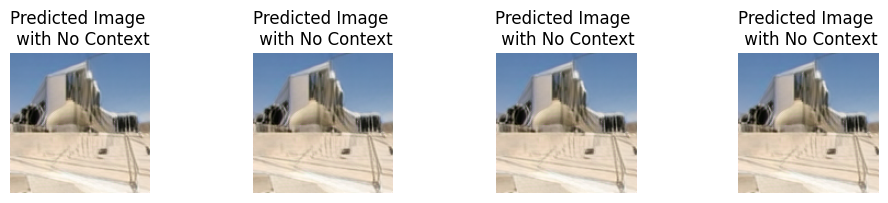

In [34]:
# Visualisation
plt.figure(figsize=(12, 4))
for i in range(output_np.shape[0]):
    # Original
    plt.subplot(2, output_np.shape[0], i + 1)
    plt.imshow(output_np[i, :, :, :])
    plt.title(f"Predicted Image \n with No Context")
    plt.axis("off")


## Conditional Inference

Note that the above is simply unconditional generation. However, it is always ideal to have additional control over the prediction process.

Therefore, I have implemented `autoregressive_infer_with_context` in the VAR model. Therefore, simply calling it can inject given image
to the middle of the generation step. However, given the very coarse scale of the image and the model, it is likely that only applying at 
the last patch (patch 5) would yields meaningful result.

For more about conditional inference, please see `infer_conditional.py` and `infer_unconditional.py`.

## TensorBoard

The original codebase uses tensorboard to manage the training process, which is what I am going to do here as well.

In [ ]:
from SinVAR.utils.misc import TensorboardLogger

# 1. Initialize logger manually
tb_lg = TensorboardLogger(log_dir='runs/test_var', filename_suffix='_notebook_run')
tb_lg.set_step(0)

# 2. Log something (optional at start)
tb_lg.update(head='debug', init_value=1.0)

# 3. During training
for g_it in range(100):
    loss = 1.0 / (g_it + 1)
    acc = g_it / 100

    # Advance step
    tb_lg.set_step()

    # Log custom metrics
    tb_lg.update(head='my_metrics', loss=loss, accuracy=acc)

# 4. Finalize
tb_lg.flush()
tb_lg.close()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch
import os

# Setup
log_dir = './runs/test_log'
writer = SummaryWriter(log_dir=log_dir)

# Dummy data logging
for step in range(10):
    writer.add_scalar("Loss/train", 0.5 / (step + 1), step)
    writer.add_scalar("Accuracy/train", step * 10, step)

writer.flush()
writer.close()

In [ ]:
# 1. Initialize logger manually
tb_lg = TensorboardLogger(log_dir='runs/test_var', filename_suffix='_notebook_run')
tb_lg.set_step(0)

# 2. Log something (optional at start)
tb_lg.update(head='debug', init_value=1.0)
for step in range(10):
    # Log dummy scalars
    tb_lg.update(head='TryAgain', Loss=0.5 / (step + 1), Accuracy=step * 10, step=step)

tb_lg.flush()
tb_lg.close()

## Dumping to Log

In [ ]:
from datetime import datetime


def dump_notebook_log(log_dir='logs', filename_prefix='notebook_run', trainer=None, metrics=None):
    os.makedirs(log_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{filename_prefix}_{timestamp}.txt"
    path = os.path.join(log_dir, filename)

    with open(path, 'w') as f:
        f.write(f"[Notebook VAR Training Log - {timestamp}]\n\n")

        if trainer:
            f.write("Trainer Config:\n")
            try:
                config = trainer.get_config()
                for k, v in config.items():
                    f.write(f"{k}: {v}\n")
                f.write("\n")
            except Exception as e:
                f.write(f"(Could not get trainer config: {e})\n\n")

        if metrics:
            f.write("Metrics:\n")
            for k, meter in metrics.meters.items():
                f.write(f"{k}: {meter.global_avg:.4f}\n")

    print(f"[✅ Log saved to] {path}")